<a href="https://colab.research.google.com/github/tomonari-masada/course2022-nlp/blob/main/assignment03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 課題3
* 春学期に習った分類手法を使って、IMDbデータセットの感情分析をしてみよう。
 * training set / test setの分割は、そのまま使う。
 * training setをどのように使うかはお任せします。（交差検証など。）
 * test setでの分類性能をArea under the ROC curveで報告。

## Intel® Extension for Scikit-learnを使ってみる
* scikit-learnが高速化されるらしいです。
 * https://intel.github.io/scikit-learn-intelex/

In [1]:
!pip install scikit-learn-intelex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 87 kB 3.6 MB/s 
     |████████████████████████████████| 26.0 MB 75.9 MB/s 
     |████████████████████████████████| 300.3 MB 18 kB/s 
     |████████████████████████████████| 4.0 MB 41.5 MB/s 


In [2]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, RocCurveDisplay

# 機械学習のモデルはsklearnexのものを使う
from sklearnex.linear_model import LogisticRegression

%config InlineBackend.figure_formats = {'png', 'retina'}

random_state = np.random.RandomState(0)

## fasttextで文書をベクトル化した場合

### データファイルを読む
* 事前にfasttextの単語ベクトルを使って各文書をembedしたデータ。

In [4]:
PATH = '/content/drive/MyDrive/2022Courses/nlp/imdb/'

texts = dict()
labels = dict()
for tag in ['train', 'test']:
  with open(f'{PATH}{tag}.npy', 'rb') as f:
    texts[tag] = np.load(f)
  with open(f'{PATH}{tag}_labels.npy', 'rb') as f:
    labels[tag] = np.load(f)

### モデルのチューニング
* ロジスティック回帰を分類モデルとして使う。
* 正則化パラメータを交差検証でチューニングする。

In [5]:
for C in [0.1, 1, 10, 100]:
  classifier = LogisticRegression(C=C, random_state=random_state, max_iter=1000)
  roc_auc = cross_val_score(classifier, texts['train'], labels['train'], cv=5, scoring='roc_auc').mean()
  print(f'C={C} | roc auc : {roc_auc:.4f}')

C=0.1 | roc auc : 0.7991
C=1 | roc auc : 0.8887
C=10 | roc auc : 0.9196
C=100 | roc auc : 0.9298


In [6]:
for C in [200, 500, 1000]:
  classifier = LogisticRegression(C=C, random_state=random_state, max_iter=1000)
  roc_auc = cross_val_score(classifier, texts['train'], labels['train'], cv=5, scoring='roc_auc').mean()
  print(f'C={C} | roc auc : {roc_auc:.4f}')

C=200 | roc auc : 0.9302
C=500 | roc auc : 0.9302
C=1000 | roc auc : 0.9300


### テストセット上で評価

In [7]:
classifier = LogisticRegression(C=200, random_state=random_state, max_iter=1000)
classifier.fit(texts['train'], labels['train'])
print(f"test roc auc : {roc_auc_score(labels['test'], classifier.predict_proba(texts['test'])[:, 1]):.4f}")

test roc auc : 0.9297


### ROC curveを描く

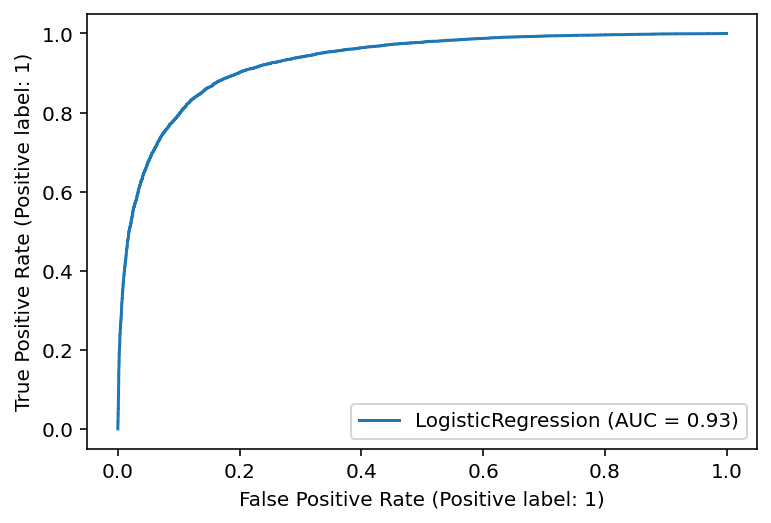

In [8]:
RocCurveDisplay.from_estimator(classifier, texts["test"], labels["test"]);

## TF-IDFで文書をベクトル化した場合

* IMDbデータセットのテキストを取得し直す

In [9]:
!pip install ml_datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
from ml_datasets import imdb
train_data, test_data = imdb()

84131840it [00:03, 25101497.19it/s]                              


Untaring file...


In [11]:
train_texts, train_labels = zip(*train_data)
test_texts, test_labels = zip(*test_data)

In [12]:
vectorizer = TfidfVectorizer(min_df=10, max_df=0.2)
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

In [13]:
print(X_train.shape, X_test.shape)

(25000, 18417) (25000, 18417)


In [14]:
for C in [0.01, 0.1, 1, 10]:
  classifier = LogisticRegression(C=C, random_state=random_state, max_iter=1000)
  mean_roc_auc = cross_val_score(classifier, X_train, train_labels, cv=5, scoring='roc_auc').mean()
  print(f'C={C} | roc auc : {roc_auc:.4f}')

C=0.01 | roc auc : 0.9300
C=0.1 | roc auc : 0.9300
C=1 | roc auc : 0.9300
C=10 | roc auc : 0.9300


In [15]:
for C in [100, 200]:
  classifier = LogisticRegression(C=C, random_state=random_state, max_iter=1000)
  mean_roc_auc = cross_val_score(classifier, X_train, train_labels, cv=5, scoring='roc_auc').mean()
  print(f'C={C} | roc auc : {roc_auc:.4f}')

C=100 | roc auc : 0.9300
C=200 | roc auc : 0.9300


In [16]:
classifier = LogisticRegression(random_state=random_state, max_iter=1000)
classifier.fit(X_train, train_labels)
print(f"test roc auc : {roc_auc_score(test_labels, classifier.predict_proba(X_test)[:, 1]):.4f}")

test roc auc : 0.9494


/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:2446: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


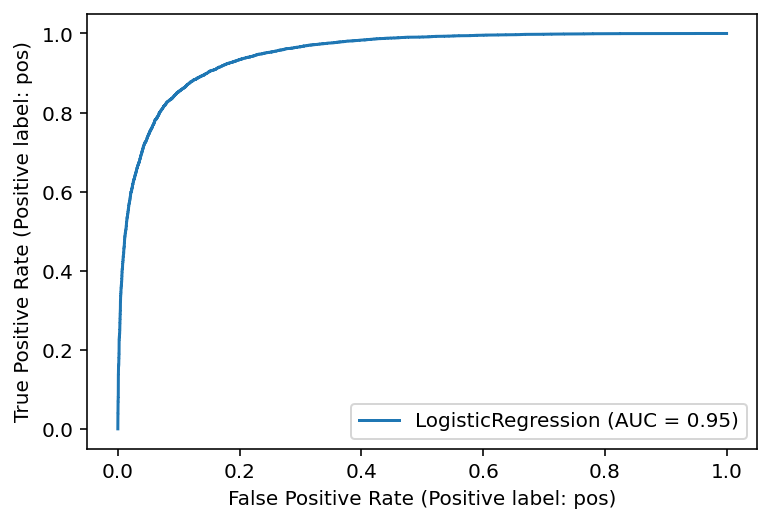

In [17]:
RocCurveDisplay.from_estimator(classifier, X_test, test_labels);